# Homework1 for Trustworthy Machine Learning

作业要求请参考PPT

如有任何问题，欢迎发邮件至助教邮箱：2301112055@stu.pku.edu.cn

## Deadline
**中文/English: 4/3 release, 4/16 24:00 due**

In [1]:
# Install other package if neccesary.
!pip install lime==0.1.1.37

In [2]:
# Import package
import torch
import json
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from torch.autograd import Variable
from typing import Callable, List, Tuple

c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


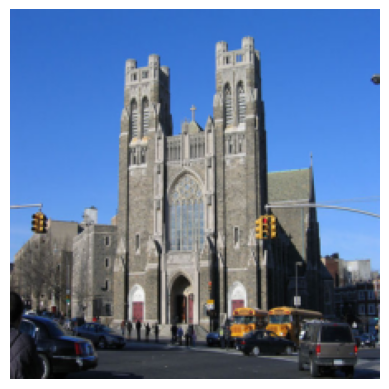

In [3]:
# Test whether the jupyter works well.
np.random.seed(10)
img = Image.open('./test.JPEG')
img = img.convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
img = transform(img)
img_hwc = img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
img = img.unsqueeze(dim=0)

In [4]:
# Load the model
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
net = resnet50(num_classes=1000, pretrained=True)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), net)
model.eval()

c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

The label of image 0 is : tench
The label of image 1 is : English_springer
The label of image 2 is : tape_player
The label of image 3 is : chain_saw
The label of image 4 is : church
The label of image 5 is : French_horn
The label of image 6 is : garbage_truck
The label of image 7 is : gas_pump
The label of image 8 is : golf_ball
The label of image 9 is : parachute


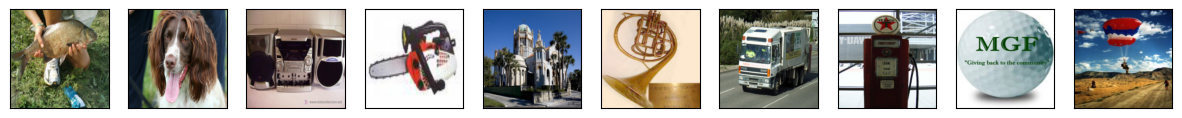

In [5]:
# Load the dataset
dataset = ImageFolder(root="./ImageNet_subset/", transform=transform)
dataset_loader = DataLoader(dataset, batch_size=10, num_workers=6)
for image, _ in dataset_loader:
    result = model(image)
    real_label = torch.argmax(result,dim = -1).numpy()


# Print the label
for j, label in enumerate(real_label):
    class_name = json.load(open("imagenet_class_index.json"))[str(label.item())]
    print("The label of image {:d} is :".format(j), class_name[1])


# Show the image
img_indices = [i for i in range(10)]
all_image,_ = next(iter(dataset_loader))
all_image = all_image.mul(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu', torch.uint8).numpy()
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(all_image):
  axs[i].imshow(img)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

# Lime
[Lime](https://github.com/marcotcr/lime) is a package about explaining what machine learning classifiers are doing. We can first use it to observe the model.

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


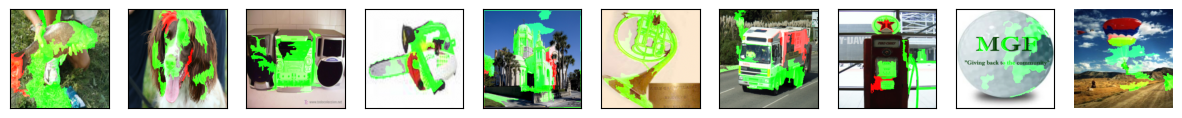

In [6]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)
    # output: the output of the model.
    ###################################
    # write the code here
    input_tensor=torch.tensor(input).permute(0,3,1,2).float()
    output = model(input_tensor)
    return output.detach().numpy()
    ###################################

def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage
    # doc: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#slic
    return slic(input, n_segments=200, compactness=1, sigma=1, start_label=1)

img_indices = [i for i in range(10)]
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))


# fix the random seed to make it reproducible
for idx, (image,label) in enumerate(zip(all_image,real_label)):
    x = (image/255).astype(np.double)

    # Refer the doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance
    ###################################
    # write the code here
    explaination = lime_image.LimeImageExplainer().explain_instance(x, predict, segmentation_fn=segmentation)
    ###################################


    # Turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    lime_img, mask = explaination.get_image_and_mask(label=label.item(),positive_only=False,hide_rest=False,num_features=11,min_weight=0.05)
    axs[idx].imshow(lime_img)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
plt.close()

## Saliency Map
What is Saliency map?

The heatmaps that highlight pixels of the input image that contribute the most in the classification task.

Ref: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

We put an image into the model, forward then calculate the loss referring to the label. Therefore, the loss is related to:

*   image
*   model parameters
*   label

Generally speaking, we change model parameters to fit "image" and "label". When backward, we calculate the partial differential value of **loss to model parameters**.

Now, we have another look. When we change the image's pixel value, the partial differential value of **loss to image** shows the change in the loss. We can say that it means the importance of the pixel. We can visualize it to demonstrate which part of the image contribute the most to the model's judgment.

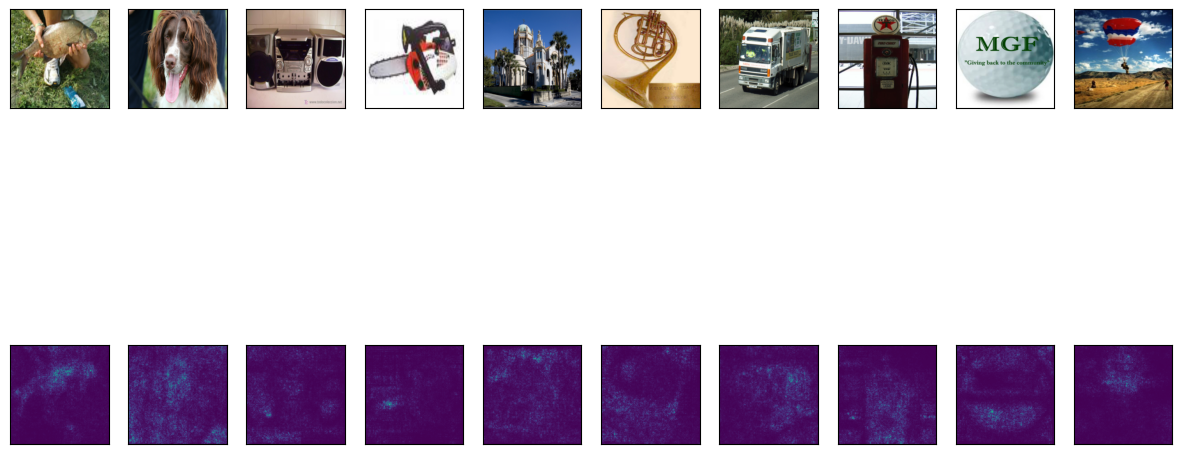

In [8]:
# Tips.
# What is permute?
# In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
# In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
# permute is a tool for permuting dimensions of tensors
# For example, img.permute(1, 2, 0) means that,
# - 0 dimension is the 1 dimension of the original tensor, which is height
# - 1 dimension is the 2 dimension of the original tensor, which is width
# - 2 dimension is the 0 dimension of the original tensor, which is channels


def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  # input: the input image, the ground truth label, the model
  # output: the saliency maps of the images
  # We need to normalize each image, because their gradients might vary in scale, use the "normalize" function.
  # pass
  ###################################
  # write the code here
  model.eval()
  x.requires_grad_()
  y_pred=model(x)
  loss_func=torch.nn.CrossEntropyLoss()
  loss=loss_func(y_pred,y)
  loss.backward()
  saliencies,_=torch.max(x.grad.data.abs().detach().cpu(),dim=1)
  saliencies=torch.stack([normalize(item) for item in saliencies])
  return saliencies
  # saliencies = []
  # for image, label in zip(x, y):
  #     image = image.unsqueeze(0)
  #     image.requires_grad_()
  # 
  #     model.zero_grad()
  #     output = model(image)
  #     score = output[0, label.item()]
  #     score.backward()

  #     saliency = image.grad.abs().squeeze().max(dim=0)[0]
  #     saliencies.append(saliency)
    
  # saliencies = [normalize(saliency) for saliency in saliencies]
  # return saliencies
  # return saliencies
  ###################################

image,_ = next(iter(dataset_loader))
result = model(image)
label = torch.argmax(result,dim = -1)



saliencies = compute_saliency_maps(image, label, model)
# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))

for row, target in enumerate([image, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
      axs[row][column].set_xticks([])
      axs[row][column].set_yticks([])
    else:
      axs[row][column].imshow(img.numpy())
      axs[row][column].set_xticks([])
      axs[row][column].set_yticks([])

plt.show()
plt.close()

## Smooth Grad
The method of Smooth grad is to randomly add noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xiaoxiangyey\.conda\envs\trustl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


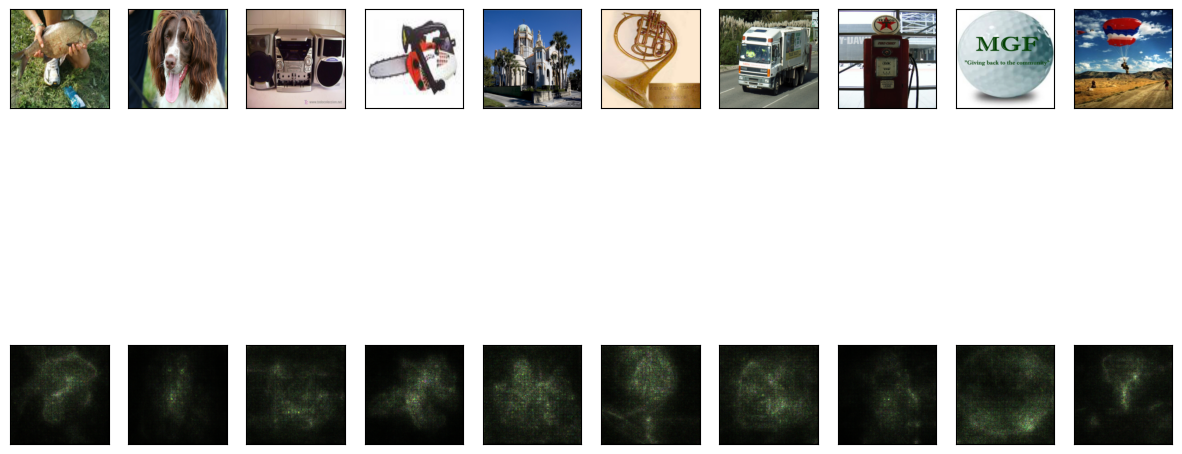

In [10]:
dataset = ImageFolder(root="./ImageNet_subset/", transform=transform)
dataset_loader = DataLoader(dataset, batch_size=10, num_workers=6)
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), resnet50(num_classes=1000, pretrained=True))
model.eval()
def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
  model.eval()
  mean=0
  sigma=param_sigma_multiplier/(torch.max(x)-torch.min(x)).item()
  smooth=np.zeros(x.unsqueeze(0).size())
  for i in range(epoch):
    noise=Variable(x.data.new(x.size()).normal_(mean,sigma**2))
    x_mod=(x+noise).unsqueeze(0)
    x_mod.requires_grad_()
    y_pred=model(x_mod)
    loss_func=torch.nn.CrossEntropyLoss()
    loss=loss_func(y_pred,y.unsqueeze(0))
    loss.backward()
    smooth+=x_mod.grad.abs().detach().cpu().data.numpy()
  smooth=normalize(smooth/epoch)
  return smooth
  # input: the input image, the ground truth label, the model, the number for average, Sigma multiplier when calculating std of noise
  # output: the saliency maps of the images
  # smooth_saliencies = []
  # for _ in range(epoch):
  #     noise = torch.randn_like(x) * param_sigma_multiplier
  #     noisy_image = x + noise
  #     noisy_image = torch.clamp(noisy_image, 0, 1)
  #     noisy_image.requires_grad_()
  #     
  #     model.zero_grad()
  #     output = model(noisy_image)
  #     score = output[0, y.item()]
  #     score.backward()
  #     
  #     saliency = noisy_image.grad.abs().squeeze()
  #     smooth_saliencies.append(saliency)
    
  # smooth_saliencies = torch.stack(smooth_saliencies).mean(dim=0)
  # smooth_saliencies = torch.stack(smooth_saliencies).mean(dim=0)
  # smooth_saliencies = [normalize(saliency) for saliency in smooth_saliencies]
  # return smooth_saliencies

smooth = []
image,_ = next(iter(dataset_loader))
result = model(image)
label = torch.argmax(result,dim = -1)
for i, l in zip(image, label):
  smooth.append(smooth_grad(i, l, model, 10, 0.4))
smooth = np.stack(smooth)
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([image, smooth]):
  for column, img in enumerate(target):
    if row==0:
        axs[row][column].imshow(img.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])
    else:
        axs[row][column].imshow(np.transpose(img.reshape(3,224,224), (1,2,0)))
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])

## CAM
The method of Grad-cam is used to get the heatmaps of the models through the intermediate features of the global pooling.

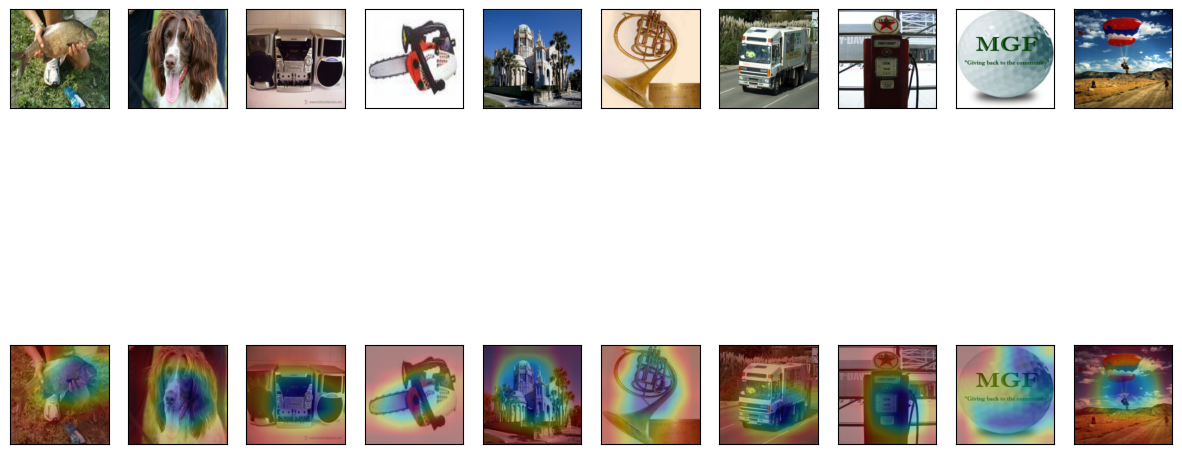

In [20]:
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2


net = models.resnet50(pretrained=True)
finalconv_name = 'layer4'

net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# calculate cam for one single image
def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    ###################################
    # write the code here
    # hint: the cam_img should be integers in [0,255] so that it can be transffered by cv2.applyColorMap later.
    cam = np.matmul(weight_softmax[class_idx], feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    
    cam_img = np.uint8(255 * cam_img)
    
    return cv2.resize(cam_img, size_upsample)


# load test image
image, _ = next(iter(dataset_loader))
logit = net(image)

h_x = F.softmax(logit, dim=1).data
probs, idx = torch.max(h_x, dim=1)
probs = probs.numpy()
idx = idx.numpy()



# generate class activation mapping for the top1 prediction
results = []
for i in range(image.shape[0]):
    CAMs = returnCAM(features_blobs[0][i], weight_softmax, idx[i])

    # render the CAM and output
    _, height, width = image[i].shape
    heatmap = np.transpose(cv2.applyColorMap(cv2.resize(CAMs,(width, height)), cv2.COLORMAP_JET), (2,0,1))
    result = heatmap * 0.3 / 255 + np.array(image[i] * 0.5)
    results.append(result)


fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([image, results]):
  for column, img in enumerate(target):
    if row==0:
        axs[row][column].imshow(img.permute(1, 2, 0).detach().mul(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy())
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])
    else:
        axs[row][column].imshow(np.transpose(img.reshape(3,224,224), (1,2,0)))
        axs[row][column].set_xticks([])
        axs[row][column].set_yticks([])